In [49]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import mdtraj as md
from scipy.optimize import curve_fit, least_squares
from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import os, sys
from scipy.stats import binned_statistic
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

se = lambda x : np.std(x)/np.sqrt(x.size)
se.__name__ = 'SE'

def error_prop_ratio(v1,v2,e1,e2):
    ratio = v1/v2
    return ratio*np.sqrt((e1/v1)**2+(e2/v2)**2)  

def calcProfiles(name,protein,replica=0,L=25,nskip=500):
    """Function to calculate csat and ccon from concentration profiles"""
    df_proteins = pd.read_csv('direct_coexistence/proteins.csv',index_col=0)
    filename = f'{name:s}_{replica:d}.npy'
    if os.path.isfile(filename):
        h = np.load(filename)[nskip:]
        fasta = df_proteins.loc[protein].fasta
        N = len(fasta)
        conv = 100/6.022/N/L/L*1e3
        h = h*conv 
        lz = h.shape[1]+1
        edges = np.arange(-lz/2.,lz/2.,1)/10
        dz = (edges[1]-edges[0])/2.
        z = edges[:-1]+dz
        profile = lambda x,a,b,c,d : .5*(a+b)+.5*(b-a)*np.tanh((np.abs(x)-c)/d)
        residuals = lambda params,*args : ( args[1] - profile(args[0], *params) )
        hm = np.mean(h,axis=0)
        z1 = z[z>0]
        h1 = hm[z>0]
        z2 = z[z<0]
        h2 = hm[z<0]
        p0=[1,1,1,1]
        res1 = least_squares(residuals, x0=p0, args=[z1, h1], bounds=([0]*4,[100]*4))
        res2 = least_squares(residuals, x0=p0, args=[z2, h2], bounds=([0]*4,[100]*4))
        
        cutoffs1 = [-10,10]
        cutoffs2 = [-60,60]

        bool1 = np.logical_and(z>cutoffs1[0],z<cutoffs1[1])
        bool2 = np.logical_or(z<cutoffs2[0],z>cutoffs2[1])

        dilarray = np.apply_along_axis(lambda a: a[bool2].mean(), 1, h)
        denarray = np.apply_along_axis(lambda a: a[bool1].mean(), 1, h)
        
        dil = hm[bool2].mean()
        den = hm[bool1].mean()

        return dil, den, dilarray, denarray
    else:
        print('DATA NOT FOUND FOR',name)
        
def plotCvsTime(ax,name,label,replica=0,L=25,nskip=500):
    df_proteins = pd.read_csv('direct_coexistence/proteins.csv',index_col=0)
    filename = f'{name:s}_{replica:d}.npy'
    hpro = np.load(filename)[:]
    hpro = hpro[nskip:]/len(df_proteins.loc[label].fasta)/L/L/0.1/6.022*10*1e3
    Lz = (hpro.shape[1]+1)/20
    im = ax.imshow(hpro,extent=[-Lz, Lz,0, hpro.shape[0]*0.002], 
                 cmap=plt.cm.Blues,
                 origin='lower',aspect='auto',norm=LogNorm(vmin=1e-2,vmax=10))
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size="5%", pad=.15)
    f.add_axes(cax)
    cb = f.colorbar(im, cax=cax, orientation="horizontal", label=f'[{label:s}] / mM')
    cax.xaxis.set_label_position('top'); cax.xaxis.set_ticks_position('top')
    ax.set_xlim(-Lz,Lz)
    
    lz = hpro.shape[1]+1
    edges = np.arange(-lz/2.,lz/2.,1)/10
    dz = (edges[1]-edges[0])/2.
    z = edges[:-1]+dz
    profile = lambda x,a,b,c,d : .5*(a+b)+.5*(b-a)*np.tanh((np.abs(x)-c)/d)
    residuals = lambda params,*args : ( args[1] - profile(args[0], *params) )
    hm = np.mean(hpro,axis=0)
    z1 = z[z>0]
    h1 = hm[z>0]
    z2 = z[z<0]
    h2 = hm[z<0]
    p0=[1,1,1,1]
    res1 = least_squares(residuals, x0=p0, args=[z1, h1], bounds=([0]*4,[100]*4))
    res2 = least_squares(residuals, x0=p0, args=[z2, h2], bounds=([0]*4,[100]*4))
    cutoffs1 = [res1.x[2]-2*res1.x[3],-res2.x[2]+2*res2.x[3]]
    cutoffs2 = [res1.x[2]+6*res1.x[3],-res2.x[2]-6*res2.x[3]]
    ax.axvline(-10)
    ax.axvline(10)
    ax.axvline(-60)
    ax.axvline(60)
    return hpro
        
def plotMap(ax,mat,vmin,vmax,xlabel,ylabel,cmap=plt.cm.bwr,
            ori='vertical',
            cbar=True,cbarlabel='$U_E$ (pH 6) - $U_E$ (pH 8)  /  J mol$^{-1}$'):
    im = ax.imshow(mat.T,extent=[0, mat.shape[1],0, mat.shape[0]], 
                 cmap=cmap,
                 origin='lower',alpha=1,
                 vmin=vmin,vmax=vmax)
    """Function to plot contact maps"""
    if cbar:
        divider = make_axes_locatable(ax)
        if ori == 'vertical':
            cax = divider.new_horizontal(size="{:.1f}%".format(5), pad=.1)
        else:
            cax = divider.new_vertical(size="{:.1f}%".format(5), pad=.1)
        f.add_axes(cax)
        cb = f.colorbar(im, cax=cax, orientation=ori,
                    label=cbarlabel)
        cax.xaxis.set_label_position('top'); cax.xaxis.set_ticks_position('top')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def calc_X_Y_mat(X_pos,Y_pos,mat):
    """Function to extract contacts between residue types from contact maps"""
    df = pd.DataFrame(0,index=X_pos,columns=Y_pos)
    for res1 in X_pos:
        for res2 in Y_pos:
            df.loc[res1,res2] = mat[res1,res2]
    return df

def calc_X_Y_mat_replica(var,X_pos,Y_pos,replica):
    """Function to extract contacts between residue types from contact maps"""
    df = pd.DataFrame(0,index=X_pos,columns=Y_pos)
    shape = np.load(f'direct_coexistence/contact_maps/replica_{replica:d}/{var:s}_{replica:d}_0_contact_map.npy').shape
    mat = np.zeros(shape)
    for chunk in range(10):
        mat += np.load(f'direct_coexistence/contact_maps/replica_{replica:d}/{var:s}_{replica:d}_{chunk:d}_contact_map.npy')
    mat = mat/10
    for res1 in X_pos:
        for res2 in Y_pos:
            df.loc[res1,res2] = mat[res1,res2]
    return df

def calc_ave_mat(var,N,replicas=[0,2,3]):
    """average over contact matrices calculated for segments of a simulation trajectory"""
    mat = np.zeros((N,N))
    for replica in replicas:
        mat_replica = np.zeros((N,N))
        for chunk in range(10):
            mat_replica += np.load(
                f'direct_coexistence/contact_maps/replica_{replica:d}/{var:s}_{replica:d}_{chunk:d}_contact_map.npy')
        np.save(f'direct_coexistence/contact_maps/{var:s}_{replica:d}_contact_map.npy',mat_replica/10)
        mat += mat_replica
    np.save(f'direct_coexistence/contact_maps/{var:s}_contact_map.npy',mat/len(replicas))

In [50]:
calc_ave_mat('CPEB4',448,replicas=[0,2,3])
calc_ave_mat('CPEB4pH6',448,replicas=[0,2,3])

In [51]:
df_proteins = pd.read_csv('direct_coexistence/proteins.csv',index_col=0)
df_proteins.fasta = df_proteins.fasta.apply(list)

In [52]:
!mkdir figures

mkdir: figures: File exists


### Methods

Molecular dynamics simulations were performed using the single-bead-per-residue model
CALVADOS 224,25 implemented in openMM v7.5. All simulations were conducted in the NVT ensemble at 20 ºC using a Langevin integrator with a time step of 10 fs and friction coefficient of 0.01 ps$^{-1}$. Configurations were saved every 2 ns. In our simulations, pH is modeled through its effect on the charge on the histidine residues ($q_{His}$).

Direct-coexistence simulations were performed with 100 chains in a cuboidal box of side lengths [Lx,Ly,Lz] = [25, 25, 300] nm. Simulations were run in $n=3$ independent replicas for at least 55 µs each. The systems readily formed a protein-rich slab spanning the periodic boundaries along the x- and y-coordinates. The initial 2 μs of the simulation trajectories were discarded and time-averaged concentration profiles along the z-axis were calculated after centering the condensates in the box as previously described. 

To model protein multimers, 400 chains were initially placed at random positions in a cubic box of side length 188 nm and simulations were run in $n=2$ replicas for 16 μs each. The formation and dissolution of protein multimers was monitored via a cluster analysis implemented in OVITO. Proteins were clustered based on the distances between their centers of mass, using a cutoff of 1.5 times the average radius of gyration of the protein. Contact maps were calculated between a chain in the middle of the condensate or multimer and the surrounding chains. Contacts were quantified via the switching function $c(r)= 0.5 − 0.5 × \tanh{[(r-\sigma_0)/r_0]}$, where $r$ is the intermolecular distance between two residues, $\sigma_0=1$ nm, and $r_0=0.3$ nm. 

To match the conditions of the experiments with which the simulation results are compared, direct-coexistence (Fig. 2 and Extended Data Fig. 2) and multimer (Fig. 3) simulations were performed at ionic strengths of 150 mM and 60 mM, respectively.

### Time evolution of multimer sizes

8.666015625 16.375
8.63671875 16.58


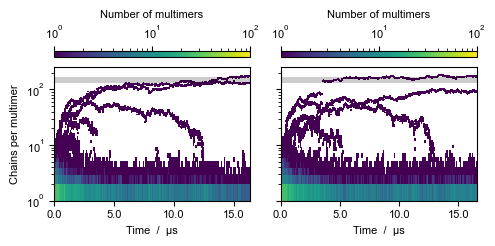

In [53]:
f, axes = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(5,2.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})

edges = np.arange(1,401,1)
x = edges[:-1]+(edges[1]-edges[0])/2.

for i in range(2):
    clust = pd.read_pickle(f'multimers/replica_{i:d}/clusters_CPEB4_60.pkl')
    rg = np.load(f'multimers/replica_{i:d}/CPEB4_400_293_60_rg.npy')
    print(rg.mean()*1.5,rg.shape[1]*5/1000)
    h = np.apply_along_axis(
        lambda a: np.histogram(a,bins=edges)[0]/x, 1, clust.size_chain_B)
    h = np.concatenate(
        [np.mean(h[i:i+10],axis=0,keepdims=True) for i in range(0,h.shape[0]//10*10,10)])
    im = axes[i].pcolor(h.T,norm=LogNorm(vmin=1,vmax=100))
    axes[i].set_ylim(1,250)
    divider = make_axes_locatable(axes[i])
    cax = divider.new_vertical(size="5%", pad=.1)
    f.add_axes(cax)
    cb = f.colorbar(im, cax=cax, orientation="horizontal",label='Number of multimers')
    cax.xaxis.set_label_position('top'); cax.xaxis.set_ticks_position('top')
    axes[i].set_xticks(range(0,h.shape[0]//10*10,100),
                         labels=[i/20 for i in range(0,h.shape[0]//10*10,100)])

    axes[i].set_yscale('log')
    axes[i].axhspan(130, 170, alpha=0.2, color='k', lw=0)
 
axes[0].set_ylabel('Chains per multimer')
axes[0].set_xlabel('Time  /  µs')
axes[1].set_xlabel('Time  /  µs')
    
plt.tight_layout()
plt.savefig('figures/multimers.png',dpi=300)
plt.show()

### Fig 2 h,k

Ratio of intermolecular contact maps at pH 6 and 8 calculated between a chain in the middle of the condensate and the surrounding chains. h) Simulation snapshot of two interacting nCPEB4-NTD chains in the center of a condensate at pH 6 showing contacts between HClust (green) and the Asp- and Glu-rich region at positions 72–147 (Neg, red). i) Simulation snapshot of two interacting nCPEB4-NTD chains in the center of a condensate at pH 8 showing contacts between HClust (green) and the Arg-rich microexon 4 (blue). j) Ratio of contacts at pH 7 and 8 between His, Arg, Lys, Phe, Tyr, Trp, Asp, and Glu residues on a chain in the middle of the condensate and the histidine residues on the surrounding chains. Data are displayed as mean±SD over $n=3$ independent simulation replicas.

/var/folders/y_/2x90pfvj0138gctc5qx9196m0000gn/T/ipykernel_83797/931232722.py:79: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


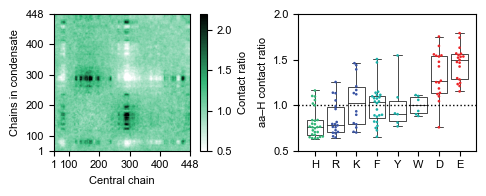

In [54]:
var = 'CPEB4'
H_pos = np.where(np.asarray(df_proteins.loc[var].fasta)=='H')[0]
R_pos = np.where(np.asarray(df_proteins.loc[var].fasta)=='R')[0]
K_pos = np.where(np.asarray(df_proteins.loc[var].fasta)=='K')[0]
E_pos = np.where(np.asarray(df_proteins.loc[var].fasta)=='E')[0]
D_pos = np.where(np.asarray(df_proteins.loc[var].fasta)=='D')[0]
F_pos = np.where(np.asarray(df_proteins.loc[var].fasta)=='F')[0]
Y_pos = np.where(np.asarray(df_proteins.loc[var].fasta)=='Y')[0]
W_pos = np.where(np.asarray(df_proteins.loc[var].fasta)=='W')[0]
N_pos = np.sort(np.concatenate([E_pos,D_pos]))
Aro_pos = np.sort(np.concatenate([F_pos,Y_pos,W_pos]))

f, (ax1,ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(5,2))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})

writer = pd.ExcelWriter('Fig2hk.xlsx', engine='xlsxwriter')

colors = [(1, 1, 1), sns.color_palette('viridis_r', 2)[0], (0, 0, 0)] # Experiment with this
cm = mpl.colors.LinearSegmentedColormap.from_list('viridis_green', colors, N=100)

mat_pH8 = np.load('direct_coexistence/contact_maps/CPEB4_contact_map.npy')

mat_pH6 = np.load('direct_coexistence/contact_maps/CPEB4pH6_contact_map.npy')

ratio = mat_pH6 / mat_pH8

pd.DataFrame(ratio,index=np.arange(1,ratio.shape[0]+1),
            columns=np.arange(1,ratio.shape[0]+1)).to_excel(writer, sheet_name='contact map ratio')

plotMap(ax1,ratio,.5,2.2,xlabel='Central chain',
    ylabel='Chains in condensate',cmap=cm,
        ori='vertical',cbar=True,cbarlabel='Contact ratio')

ax1.set_yticks([0.5]+list(np.arange(49.5,409.5,100))+[447.5],
                   ['{:d}'.format(int(i)) for i in [1]+list(range(100,410,100))+[448]])
ax1.set_xticks([0.5]+list(np.arange(49.5,409.5,100))+[447.5],
                   ['{:d}'.format(int(i)) for i in [1]+list(range(100,410,100))+[448]])

####################################

ylorbr = mpl.colormaps['viridis']
colors = ylorbr(np.arange(0,.9,.1))
colors = ['#33B779','#3954A4','#3954A4','#19B0A9','#19B0A9','#19B0A9','#EC2427','#EC2427']

residues = np.empty(0)
contacts = np.empty(0)
for res_pos,res in zip([H_pos,R_pos,K_pos,F_pos,Y_pos,W_pos,D_pos,E_pos],
                       ['H', 'R', 'K', 'F', 'Y', 'W', 'D', 'E']):
    contacts_8 = calc_X_Y_mat(res_pos,H_pos,mat_pH8) 
    contacts_6 = calc_X_Y_mat(res_pos,H_pos,mat_pH6) 
    du = (contacts_6/contacts_8).mean(axis=1).values.flatten()
    contacts = np.append(contacts,du.tolist())
    residues = np.append(residues,[res]*du.size)
H_contacts = pd.DataFrame({'residues':residues,'contacts':contacts})

H_contacts.set_index('residues').to_excel(writer, sheet_name='aa–H contact ratio')

#print(H_contacts)

sns.swarmplot(ax=ax2,data=H_contacts,x='residues',y='contacts',hue='residues',
              size=2,legend=False,s=1.9,palette=colors)
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}
sns.boxplot(ax=ax2,data=H_contacts,x='residues',y='contacts',color='w', 
            whis=(0, 100),linewidth=.5,**PROPS)

####################################

ax2.set_ylabel('aa–H contact ratio')
ax2.set_xlabel('')
ax2.hlines(1,-.8,7.8,ls=':',color='k',lw=1)
ax2.set_xlim(-.8,7.8)
ax2.set_ylim(.5,2)
ax2.set_yticks([.5,1,1.5,2])
writer.save()
    
plt.tight_layout(w_pad=0)
plt.savefig('figures/fig2hk.svg')    
plt.show()

### Extended Data Fig 2 n

Middle panel: ratio of contacts at $q_{His}=0.50$ vs $q_{His}=0.01$ between His (green circles) or Arg residues (blue squares) and charged residues (closed symbols), and vice versa (open circles). Bottom panel: ratio of contacts at $q_{His}=0.50$ vs $q_{His}=0.01$ between aromatic (cyan circles) or Arg residues (blue squares) and His residues (closed symbols), and vice versa (open symbols). Both open and closed symbols show contacts between residues on a chain in the middle of the condensate and the surrounding chains. Data represents mean ± SD over $n=3$ indipendent simulation replicas.

27 36 36 36
18 36 36 36
27 36 27 27
18 36 18 18
27 36 (27, 2)
27 18 (27, 2)


/var/folders/y_/2x90pfvj0138gctc5qx9196m0000gn/T/ipykernel_83797/3675805150.py:69: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


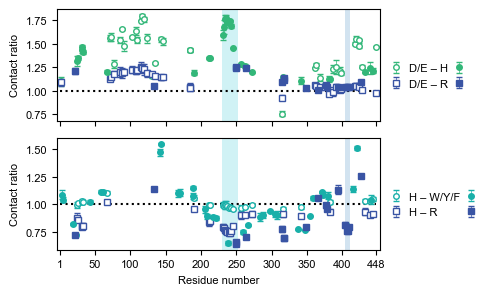

In [55]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(5,3))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})

colors = ['#33B779','#3954A4','#3954A4','#19B0A9','#19B0A9','#19B0A9','#EC2427','#EC2427']

replicas = [0,2,3]

writer = pd.ExcelWriter('ED_Fig2n.xlsx', engine='xlsxwriter')

for res_pos,label,c,m in zip([H_pos,R_pos],['D/E – H','D/E – R'],
                           ['#33B779','#3954A4'],['o','s']):

    mean_std = pd.DataFrame()
    for i in replicas:
        contact_8 = calc_X_Y_mat_replica('CPEB4',N_pos,res_pos,i) 
        contact_6 = calc_X_Y_mat_replica('CPEB4pH6',N_pos,res_pos,i)
        mean_std[i] = (contact_6/contact_8).agg('mean',axis=1)
    mean_std = mean_std.agg(['mean','std'],axis=1)
    mean_std.to_excel(writer, sheet_name=label.replace('/','_')+' open symbols')
    print(res_pos.size,N_pos.size,mean_std['mean'].size,mean_std['std'].size)
    ax1.errorbar(x=N_pos,y=mean_std['mean'],color=c,lw=0,marker=m,mfc='w',
        yerr=mean_std['std'],elinewidth=0.5,capsize=2,ms=4,label=label)

for res_pos,label,c,m in zip([H_pos,R_pos],['D/E – H','D/E – R'],
                           ['#33B779','#3954A4'],['o','s']):
    
    mean_std = pd.DataFrame()
    for i in replicas:
        contact_8 = calc_X_Y_mat_replica('CPEB4',res_pos,N_pos,i) 
        contact_6 = calc_X_Y_mat_replica('CPEB4pH6',res_pos,N_pos,i)
        mean_std[i] = (contact_6/contact_8).agg('mean',axis=1)
    mean_std = mean_std.agg(['mean','std'],axis=1)
    mean_std.to_excel(writer, sheet_name=label.replace('/','_')+' closed symbols')
    print(res_pos.size,N_pos.size,mean_std['mean'].size,mean_std['std'].size)
    ax1.errorbar(x=res_pos,y=mean_std['mean'],color=c,lw=0,marker=m,
        yerr=mean_std['std'],elinewidth=0.5,capsize=2,ms=4,label=' ')
    
for res_pos,label,c,m in zip([Aro_pos,R_pos],['H – W/Y/F','H – R'],
                           ['#19B0A9','#3954A4'],['o','s']):
    
    mean_std = pd.DataFrame()
    for i in replicas:
        contact_8 = calc_X_Y_mat_replica('CPEB4',H_pos,res_pos,i) 
        contact_6 = calc_X_Y_mat_replica('CPEB4pH6',H_pos,res_pos,i)
        mean_std[i] = (contact_6/contact_8).agg('mean',axis=1)
    mean_std = mean_std.agg(['mean','std'],axis=1)
    mean_std.to_excel(writer, sheet_name=label.replace('/','_')+' open symbols')
    print(H_pos.size,res_pos.size,mean_std.shape)
    ax2.errorbar(x=H_pos,y=mean_std['mean'],color=c,lw=0,marker=m,mfc='w',
        yerr=mean_std['std'],elinewidth=0.5,capsize=2,label=label,ms=4)
    
for res_pos,label,c,m in zip([Aro_pos,R_pos],['H – W/Y/F','H – R'],
                           ['#19B0A9','#3954A4'],['o','s']):
    
    mean_std = pd.DataFrame()
    for i in replicas:
        contact_8 = calc_X_Y_mat_replica('CPEB4',res_pos,H_pos,i) 
        contact_6 = calc_X_Y_mat_replica('CPEB4pH6',res_pos,H_pos,i)
        mean_std[i] = (contact_6/contact_8).agg('mean',axis=1)
    mean_std = mean_std.agg(['mean','std'],axis=1)
    mean_std.to_excel(writer, sheet_name=label.replace('/','_')+' closed symbols')
    ax2.errorbar(x=res_pos,y=mean_std['mean'],color=c,lw=0,marker=m,
        yerr=mean_std['std'],elinewidth=0.5,capsize=2,ms=4,label=' ')

ax1.hlines(1,1,448,ls=':',color='k')

ax2.hlines(1,1,448,ls=':',color='k')

writer.save()

for ax in [ax1,ax2]:
    ax.axvspan(229, 252, alpha=0.2, color='tab:cyan', lw=0)
    ax.axvspan(403, 410, alpha=0.2, color='tab:blue', lw=0)

ax2.set_xlim(1-5,448+5)
ax2.set_xticks([1]+list(range(50,410,50))+[448])

ax1.set_ylabel(r'Contact ratio')
ax2.set_ylabel(r'Contact ratio')

ax1.legend(loc=(1,.25),handletextpad=.2,frameon=False,ncol=2,columnspacing=0)
ax2.legend(loc=(1,.25),handletextpad=.2,frameon=False,ncol=2,columnspacing=0)

ax2.set_xlabel('Residue number')
plt.tight_layout()
plt.savefig('figures/ext_data_fig2n.svg')    
plt.show()

### Fig 3 h

Total contacts formed between residues on a chain in the middle of a multimeric particle and all the residues on the surrounding chains in the CALVADOS simulations. Contacts are obtained from molecular simulations averaging over multimers of 130-170 chains with an average radius of gyration of 17.5±0.5 nm. Data are displayed as averages and standard errors calculated over windows of ten residues.

149.68081063964536 17.466856126361186 0.05318331991786337


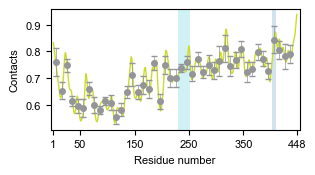

In [56]:
fig, ax1 = plt.subplots(1,1,figsize=(3.2,1.8))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})

profile = np.zeros(448)
n_frames_tot = 0
rgs = np.empty(0)
kappas = np.empty(0)
sizes = np.empty(0)

for i,s in enumerate(range(135,170,10)):
    for replica in range(2):
        filename = f'multimers/replica_{replica:d}/CPEB4_s3_293_60_{s:d}.npy'
        if os.path.isfile(filename):
            size,rg,kappa = np.loadtxt(
                f'multimers/replica_{replica:d}/CPEB4_size_rg_kappa_293_60_{s:d}.dat',unpack=True)
            sizes = np.append(sizes,size)
            rgs = np.append(rgs,rg)
            kappas = np.append(kappas,kappa)
            n_frames = sizes.size
            profile += np.load(filename).sum(axis=1)*n_frames
            n_frames_tot += n_frames
profile /= n_frames_tot

res_num = np.arange(1,profile.size+1,1)
    
y = gaussian_filter1d(profile, 2)
bins = res_num[::10]
ax1.plot(res_num,y,color='#CCDC2C',label='Droplet',lw=1)

wa_ene = binned_statistic(res_num,profile,bins=bins)[0]
wa_ene_err = binned_statistic(res_num,profile,bins=bins,statistic=se)[0]

ax1.errorbar(x=bins[:-1]+5,y=wa_ene,lw=0,marker='o',ms=4,
    yerr=wa_ene_err,elinewidth=0.5,capsize=2,color='#939598')

pd.DataFrame(data={'mean':wa_ene,'SE':wa_ene_err},index=bins[:-1]+5).to_excel('Fig3h.xlsx')

print(np.mean(sizes),np.mean(rgs),np.mean(kappas))

plt.xlim(1-5,448+5)
plt.xticks([1]+list(range(50,410,100))+[448])

plt.axvspan(229, 252, alpha=0.2, color='tab:cyan', lw=0)
plt.axvspan(403, 410, alpha=0.2, color='tab:blue', lw=0)

#plt.legend()
plt.xlabel('Residue number')
plt.ylabel('Contacts')
plt.tight_layout()
plt.savefig('figures/fig3h.svg')
plt.show()

### Extended Data Fig 2 l,m

Comparison between the saturation concentrations from experiments (30 μM nCPEB4-NTD with 100 mM NaCl at 40 ºC and pH 8) and molecular simulations (at 20 ºC with $q_{His}$ 0.01) of nCPEB4-NTD and the His to Ser variants. The experimental saturation concentrations are represented as mean ± SD of three measurements of the same sample. $q_{His}$ indicates the charge of the His residues. m) Saturation concentrations (black, left axis) and dense phase concentrations (gray, right axis) from molecular simulations of nCPEB4-NTD with qHis 0.50 (nCPEB4 $q_{His}$ 0.50), 0.10 (nCPEB4 $q_{His}$ 0.10) and 0.01 (nCPEB4), and of the $q_{His}$ to Ser variants with $q_{His}$ 0.01. The simulation data are represented as mean±SD over $n=3$ independent simulation replicas.

In [57]:
variants = ['WT_pH6','WT_pH7','WT','H25S_Clust','H25S','H50S_Clust','H50S']

df_conc = pd.DataFrame(index=variants)

names = ['CPEB4pH6','CPEB4pH7','CPEB4','CPEB4H25S_Clust','CPEB4H25S','CPEB4H50S_Clust','CPEB4H50S']

for i,(name,variant) in enumerate(zip(names,variants)):
    csat_replicas = []
    ccon_replicas = []
    for replica in range(4):
        filename = f'direct_coexistence/{name:s}_{replica:d}.npy'
        if os.path.exists(filename):
            nskip = 1000
            csat, ccon, csatarray, _ = calcProfiles('direct_coexistence/'+name,name,
                                                    replica=replica,L=25,nskip=nskip)
            print(name,replica,csatarray.size*.002,csatarray.size,csat*1e3)
            csat_replicas.append(csat*1e3)
            ccon_replicas.append(ccon)
            df_conc.loc[variant,f'csat_{replica:d}/µM'] = csat*1e3
            df_conc.loc[variant,f'ccon_{replica:d}/mM'] = ccon
    df_conc.loc[variant,'csat_mean/µM'] = np.mean(csat_replicas)
    df_conc.loc[variant,'csat_sd/µM'] = np.std(csat_replicas)
    df_conc.loc[variant,'ccon_mean/mM'] = np.mean(ccon_replicas)
    df_conc.loc[variant,'ccon_sd/mM'] = np.std(ccon_replicas)
df_conc.to_csv('ED_Fig2lm.csv')
df_conc.to_excel('ED_Fig2lm.xlsx')

CPEB4pH6 0 57.822 28911 49.110014285998076
CPEB4pH6 2 55.0 27500 48.35028177107292
CPEB4pH6 3 55.0 27500 49.06746211462333
CPEB4pH7 0 58.646 29323 47.49347560183979
CPEB4pH7 2 54.0 27000 67.00602469565526
CPEB4pH7 3 54.0 27000 61.998506212085815
CPEB4 0 67.97200000000001 33986 80.61151461302126
CPEB4 2 64.0 32000 74.92100414386783
CPEB4 3 64.0 32000 70.72821282282587
CPEB4H25S_Clust 0 57.118 28559 81.73198824643205
CPEB4H25S_Clust 2 58.0 29000 98.81967973842349
CPEB4H25S_Clust 3 58.0 29000 85.9923802470679
CPEB4H25S 0 53.032000000000004 26516 84.43554614156416
CPEB4H25S 2 54.0 27000 94.23798145776023
CPEB4H25S 3 54.0 27000 93.21185464193627
CPEB4H50S_Clust 0 86.4 43200 109.33574843811849
CPEB4H50S_Clust 2 87.0 43500 102.52394507253027
CPEB4H50S_Clust 3 86.498 43249 97.07732456162077
CPEB4H50S 0 63.372 31686 99.30695459561045
CPEB4H50S 2 64.0 32000 93.7138334209746
CPEB4H50S 3 64.0 32000 106.42821662007776


In [58]:
variants = ['WT','H25S','H50S','H25S_Clust','H50S_Clust']

cs_100 = pd.read_csv('direct_coexistence/csat_exp_30uMprotein_100mMNaCl_40C.csv',
                   index_col=0).loc[variants]

df_c2 = pd.read_csv('ED_Fig2lm.csv',index_col=0)

0.9056571196861469
-0.9697274085466795
-0.9136974735961362


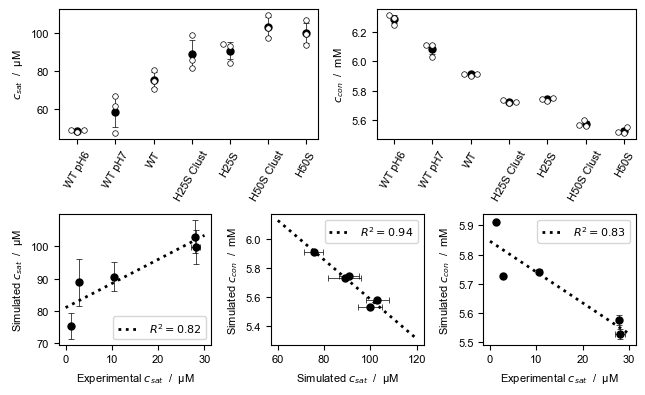

In [59]:
fig = plt.figure(figsize=(6.5,4))
ax1 = plt.subplot2grid( (2,6), (0,0), rowspan=1, colspan=3 )
ax2 = plt.subplot2grid( (2,6), (0,3), rowspan=1, colspan=3 )
ax3 = plt.subplot2grid( (2,6), (1,0), rowspan=1, colspan=2 )
ax4 = plt.subplot2grid( (2,6), (1,2), rowspan=1, colspan=2 )
ax5 = plt.subplot2grid( (2,6), (1,4), rowspan=1, colspan=2 )
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})
                  
variants = ['WT_pH6','WT_pH7','WT','H25S_Clust','H25S','H50S_Clust','H50S']

replicas = [0,2,3]

df_csat_box_60_293 = pd.DataFrame(dict(zip(variants,[[df_c2.loc[variant,f'csat_{replica:d}/µM'] 
     for replica in replicas] 
     for variant in variants])))
df_csat_box_60_293 = df_csat_box_60_293.unstack().reset_index().drop('level_1',axis=1).rename(
    {'level_0':'variants',0:'csat/µM'},axis=1)

df_ccon_box_60_293 = pd.DataFrame(dict(zip(variants,[[df_c2.loc[variant,f'ccon_{replica:d}/mM'] 
     for replica in replicas] 
     for variant in variants])))
df_ccon_box_60_293 = df_ccon_box_60_293.unstack().reset_index().drop('level_1',axis=1).rename(
    {'level_0':'variants',0:'ccon/mM'},axis=1)

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

sns.swarmplot(ax=ax1,data=df_csat_box_60_293,x='variants',y='csat/µM',
              size=2,legend=False,s=4,color='w',edgecolor='k',linewidth=.5)

sns.swarmplot(ax=ax2,data=df_ccon_box_60_293,x='variants',y='ccon/mM',
              size=2,legend=False,s=4,color='w',edgecolor='k',linewidth=.5)

ax1.errorbar(variants, df_c2.loc[variants,'csat_mean/µM'],
         marker='o',yerr=df_c2.loc[variants,'csat_sd/µM'], 
         lw=0, ms=5, elinewidth=.5, capsize=2, capthick=.5, 
         color='k',zorder=0)
ax2.errorbar(variants, df_c2.loc[variants,'ccon_mean/mM'],
         marker='o',yerr=df_c2.loc[variants,'ccon_sd/mM'],
         lw=0, ms=5, elinewidth=.5, capsize=2, capthick=.5, 
         color='k',zorder=0)

ax1.set_ylabel('$c_{sat}$  /  µM')
ax2.set_ylabel('$c_{con}$  /  mM')
ax1.set_xlabel('')
ax2.set_xlabel('')

labels = [name.replace('_',' ') for name in variants]
for ax in (ax1,ax2):
    for tick in ax.get_xticklabels():
        tick.set_rotation(60)
    ax.set_xticks(variants)
    ax.set_xticklabels(labels)
    
variants = ['WT','H25S_Clust','H25S','H50S_Clust','H50S']

csat_exp = pd.read_csv('direct_coexistence/csat_exp_30uMprotein_100mMNaCl_40C.csv',
                   index_col=0)

x = np.linspace(0, 30,1000)


ax3.errorbar(csat_exp.loc[variants].csat_mean, df_c2.loc[variants,'csat_mean/µM'],
         xerr=csat_exp.loc[variants].csat_std,yerr=df_c2.loc[variants,'csat_sd/µM'], 
         marker='o', lw=0, ms=5, elinewidth=.5, capsize=2, capthick=.5,
         color='k')
popt,_ = curve_fit(lambda x,a,b : a*x+b,csat_exp.loc[variants].csat_mean, df_c2.loc[variants,'csat_mean/µM'])

pr = pearsonr(csat_exp.loc[variants].csat_mean, df_c2.loc[variants,'csat_mean/µM'])[0]
ax3.plot(x,popt[0]*x+popt[1],ls=':',lw=2,zorder=4,color='k',label=f'$R^2={pr**2:.2f}$')
print(pr)

ax3.set_ylabel('Simulated $c_{sat}$  /  µM')
ax3.set_xlabel('Experimental $c_{sat}$  /  µM')

ax3.legend()

#####

x = np.linspace(60, 120,1000)

ax4.errorbar(df_c2.loc[variants,'csat_mean/µM'], df_c2.loc[variants,'ccon_mean/mM'],
         xerr=df_c2.loc[variants,'csat_sd/µM'],yerr=df_c2.loc[variants,'ccon_sd/mM'], 
         marker='o', lw=0, ms=5, elinewidth=.5, capsize=2, capthick=.5,
         color='k')
popt,_ = curve_fit(lambda x,a,b : a*x+b,df_c2.loc[variants,'csat_mean/µM'], 
                   df_c2.loc[variants,'ccon_mean/mM'])

pr = pearsonr(df_c2.loc[variants,'csat_mean/µM'], df_c2.loc[variants,'ccon_mean/mM'])[0]
ax4.plot(x,popt[0]*x+popt[1],ls=':',lw=2,zorder=4,color='k',label=f'$R^2={pr**2:.2f}$')
print(pr)

ax4.set_ylabel('Simulated $c_{con}$  /  mM')
ax4.set_xlabel('Simulated $c_{sat}$  /  µM')

ax4.legend()

#####

x = np.linspace(0, 30,1000)

ax5.errorbar(csat_exp.loc[variants].csat_mean, df_c2.loc[variants,'ccon_mean/mM'],
         xerr=csat_exp.loc[variants].csat_std,yerr=df_c2.loc[variants,'ccon_sd/mM'], 
         marker='o', lw=0, ms=5, elinewidth=.5, capsize=2, capthick=.5,
         color='k')
popt,_ = curve_fit(lambda x,a,b : a*x+b,csat_exp.loc[variants].csat_mean, df_c2.loc[variants,'ccon_mean/mM'])

pr = pearsonr(csat_exp.loc[variants].csat_mean, df_c2.loc[variants,'ccon_mean/mM'])[0]
ax5.plot(x,popt[0]*x+popt[1],ls=':',lw=2,zorder=4,color='k',label=f'$R^2={pr**2:.2f}$')
print(pr)

ax5.set_ylabel('Simulated $c_{con}$  /  mM')
ax5.set_xlabel('Experimental $c_{sat}$  /  µM')

ax5.legend()

plt.tight_layout()
plt.savefig('figures/ext_data_fig2lm.svg')    
plt.show()

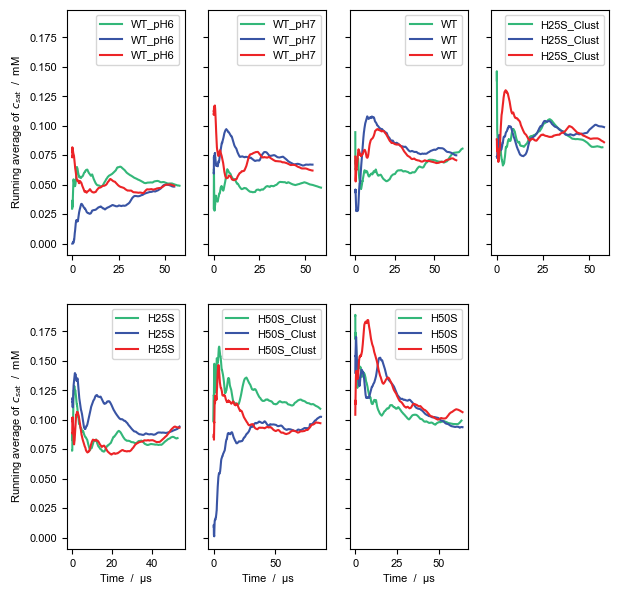

In [60]:
csat_exp = pd.read_csv('direct_coexistence/csat_exp_30uMprotein_100mMNaCl_40C.csv',
                   index_col=0)

variants = ['WT_pH6','WT_pH7','WT','H25S_Clust','H25S','H50S_Clust','H50S']
names = ['CPEB4pH6','CPEB4pH7','CPEB4','CPEB4H25S_Clust','CPEB4H25S','CPEB4H50S_Clust','CPEB4H50S']
colors = ['#33B779','#3954A4','#EC2427']

fig, axes = plt.subplots(2, 4, sharex=False, sharey=True, figsize=(7,7))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})

for ax,name,variant in zip(axes.flatten(),names,variants):

    for i,c in zip([0,2,3],colors):
        dil, den, dilarray, denarray = calcProfiles(f'direct_coexistence/{name:s}',
                                       f'{name:s}',replica=i,L=25,nskip=1000)


        ax.plot(np.arange(0,dilarray.size*.002,.002),
                np.cumsum(dilarray)/np.arange(1,dilarray.size+1),
                label=variant,color=c)
    ax.legend()

for ax in  axes[:,0]:    
    ax.set_ylabel('Running average of $c_{sat}$  /  mM')
for ax in  axes[1,:]:
    ax.set_xlabel('Time  /  µs')
axes[1,-1].set_axis_off()